## Построение модели машинного обучения
Попробуем произвести точечное предсказание на 24 часа вперед, для какого-нибудь события, например, ARRIVAL_EVENT_830304.0_862108.0 - прибытие вагонов со станции 830304 на 862108

In [239]:
#!c1.8
import sklearn
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor


df = pd.read_csv('concl.csv')
df['count'] = df['count'].interpolate().astype('int32')
# размер временного окна предыдущих событий, которое использует модель в качестве фичей, здесь 100 часов
size = 100
# точечное предсказание через gap_predict
gap_predict = 24
value_for_predict = 'ARRIVAL_EVENT_830200.0_862108.0'
train_size = 0.7

### Функция преобразует исходные данные 
### в набор фичей, где в каждой строчке 
### хранится события за size_window часов 
### и текущее значение целевой переменной
### Структура датасета становится слудующей
### |---------------------------------------------------------------------------------------------------------
### |Событие 1 за w_size  | Событие 2 за w_size|...| Событие n за w_size |Событие 1 за w_size-1|...|Событие n
### |часов до тек. момента| часов до           |...| часов до            |часов до тек. момента|...|на тек. момент
def generate_features_for_model(dataframe, size, target_current):
    list_s = []
    tr = pd.DataFrame()
    
    for i in range(0, len(dataframe)-size+1):    
        dtype = pd.SparseDtype(dtype = 'Sparse[int]', fill_value=0)
     
        row = np.array(dataframe.iloc[i: i+size].stack().append(pd.Series(target_current.iloc[i]), 
                                                       ignore_index=True)).astype('uint16')
        list_s.append(row)
        if i % round(len(dataframe) / 10) == 0:
            print("Generate done: ", round(i*100/(len(dataframe)-size+1)), '%')
    print("Generate completed")    
    ### Используем структуру данных для разреженных матриц
    return csr_matrix(list_s)

### Функция обучает модель переданную в качестве параметра regressor
### size_window - размер временного окна предыдущих событий, которое использует модель в качестве фичей, по деволту 100 часов 
### gap_predict - предсказание вперед на gap_predict часов
### value_for_predict имя переменной для предсказания
def create_model(df, regressor , size_window = 100, gap_predict = 24, value_for_predict = 'count', train_size = 0.7):
    # количество вагонов в датачете имеет пропуски - сделаем линейную интерполяцию
    

    Y = df[value_for_predict].astype('int32')
    # Удаляем целевую переменную из фичей
    X = df.drop([value_for_predict], axis = 1)
    # Готовим данные для теста
        
    X_test = X.iloc[int(len(df) * train_size) : len(df)]
    Y_test = Y[gap_predict + int(len(df)*train_size): len(df)]
   
    #Готовим тренировочный датасет
    X_train = X.iloc[0: int( len(df) * train_size)] 
    Y_current = Y[size_window - 1: size_window + int( len(df)* train_size) - 1]
    df_predict = generate_features_for_model(X_train, size_window, Y_current)
    Y_train = Y[size_window + gap_predict: size_window + gap_predict + df_predict.shape[0]]

    regressor.fit(df_predict, Y_train)
    return regressor

model = create_model(df, RandomForestRegressor(n_jobs = -1, verbose = 2), size, gap_predict, value_for_predict, train_size )

Generate done:  0 %
Generate done:  12 %
Generate done:  25 %
Generate done:  37 %
Generate done:  49 %
Generate done:  62 %
Generate done:  74 %
Generate done:  86 %
Generate done:  99 %
Generate completed
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building t

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.5min finished


In [240]:
#!c1.8
# df = pd.read_csv('concl.csv')

### Функция предсказывает целевую переменную с помощью модели  model
### size_window - размер временного окна предыдущих событий, которое использует модель в качестве фичей, по деволту 100 часов 
### gap_predict - предсказание вперед на gap_predict часов
### value_for_predict имя переменной для предсказания
def predict(df, model, size_window = 100, gap_predict = 24, value_for_predict = 'count', train_size = 0.7):

    Y = df[value_for_predict].astype('int32')
    # Удаляем целевую переменную из фичей
    X = df.drop([value_for_predict], axis = 1)
    # Готовим данные для теста
    Y_current_test = Y[size_window + int(len(df)*train_size) - 1 : len(df)]

    X_test = X.iloc[int(len(df)*train_size) : len(df)]
    df_test = generate_features_for_model(X_test, size_window, Y_current_test)
    result = model.predict(df_test).round()
    return result

result = predict(df, model, size, gap_predict, value_for_predict, train_size, )

Generate done:  0 %
Generate done:  18 %
Generate done:  35 %
Generate done:  53 %
Generate done:  70 %
Generate done:  88 %
Generate completed


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.6s finished


In [241]:
#!c1.8
result

array([1., 1., 1., 2., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 2., 2., 2., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 2., 2., 1., 2., 0., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 0., 2., 1., 1., 1., 1.,
       1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 1.])

In [242]:
#!c1.8
true_Y = df[value_for_predict][int(len(df)*0.7) + size + gap_predict - 1: len(df)]


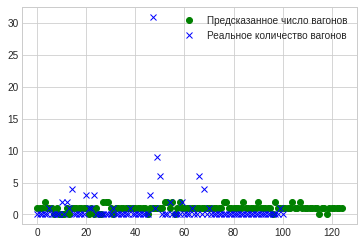

In [243]:
#!c1.8
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

plt.plot( range(0, len(result)), result, 'o', color='green', label = 'Предсказанное число вагонов')
plt.plot( range(0, len(true_Y)), true_Y, 'x', color='blue', label='Реальное количество вагонов')
plt.legend()

In [244]:
#!c1.8
# Количество реально прибывших вагонов за период времени в 105 часов
sum(true_Y)

87.0

In [245]:
#!c1.8
# # Количество предсказанных вагонов за период времени в 105 часов
sum(result[0: len(true_Y)])

101.0

### Прогноз на 36 часов вперед, исходя из текущей ситуации
Попробуем произвести прогноз на 36 часов вперед, используя 36 обученных моделей:

In [247]:
#!c1.8
predictions = list()
for gap_predict1 in range(1, 37):
    print("Current gap ", gap_predict1)
    model = create_model(df, RandomForestRegressor(n_jobs = -1, verbose = 1), size, gap_predict1, value_for_predict, train_size )
    result = predict(df, model, size, gap_predict1, value_for_predict, train_size, )
    predictions.append(result[0])

Current gap  1
Generate done:  0 %
Generate done:  12 %
Generate done:  25 %
Generate done:  37 %
Generate done:  49 %
Generate done:  62 %
Generate done:  74 %
Generate done:  86 %
Generate done:  99 %
Generate completed
Generate done:  0 %
Generate done:  18 %
Generate done:  35 %
Generate done:  53 %
Generate done:  70 %
Generate done:  88 %
Generate completed
Current gap  2
Generate done:  0 %
Generate done:  12 %
Generate done:  25 %
Generate done:  37 %
Generate done:  49 %
Generate done:  62 %
Generate done:  74 %
Generate done:  86 %
Generate done:  99 %
Generate completed
Generate done:  0 %
Generate done:  18 %
Generate done:  35 %
Generate done:  53 %
Generate done:  70 %
Generate done:  88 %
Generate completed
Current gap  3
Generate done:  0 %
Generate done:  12 %
Generate done:  25 %
Generate done:  37 %
Generate done:  49 %
Generate done:  62 %
Generate done:  74 %
Generate done:  86 %
Generate done:  99 %
Generate completed
Generate done:  0 %
Generate done:  18 %
Gener

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parall

In [248]:
#!c1.8
predictions

[0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0]

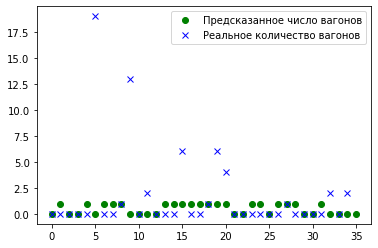

In [254]:
#!c1.8
true_Y1 = df[value_for_predict][int(len(df)*0.7) + size + 1: int(len(df)*0.7) + size + 36]

plt.plot( range(0, len(predictions)), predictions, 'o', color='green', label = 'Предсказанное число вагонов')
plt.plot( range(0, len(true_Y1)), true_Y1, 'x', color='blue', label='Реальное количество вагонов')
plt.legend()

In [258]:
#!c1.8
print("Количество предсказанных вагонов по данному событию за 36 часов:")
sum(predictions)

Количество предсказанных вагонов по данному событию за 36 часов:


19.0

In [260]:
#!c1.8
print("Реальное количество вагонов по данному событию за 36 часов:")
sum(true_Y1)

Реальное количество вагонов по данному событию за 36 часов:


57.0


### Предсказание количества вагонов размещенных на текущий момент на станции, на 24 часа вперед

Generate done:  0 %
Generate done:  12 %
Generate done:  25 %
Generate done:  37 %
Generate done:  49 %
Generate done:  62 %
Generate done:  74 %
Generate done:  86 %
Generate done:  99 %
Generate completed
Generate done:  0 %
Generate done:  18 %
Generate done:  35 %
Generate done:  53 %
Generate done:  70 %
Generate done:  88 %
Generate completed


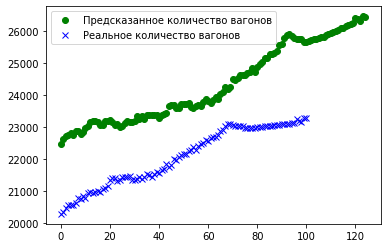

In [262]:
#!c1.8
df = pd.read_csv('concl.csv')
df['count'] = df['count'].interpolate().astype('int32')
# размер временного окна предыдущих событий, которое использует модель в качестве фичей, здесь 100 часов
size = 100
# точечное предсказание через gap_predict
gap_predict = 24
value_for_predict = 'count'
train_size = 0.7
model = create_model(df, LinearRegression(), size, gap_predict, value_for_predict, train_size )
result = predict(df, model, size, gap_predict, value_for_predict, train_size, )
true_Y = df[value_for_predict][int(len(df)*0.7) + size + gap_predict - 1: len(df)]
plt.plot( range(0, len(result)), result, 'o', color='green', label = 'Предсказанное количество вагонов')
plt.plot( range(0, len(true_Y)), true_Y, 'x', color='blue', label='Реальное количество вагонов')
plt.legend()

#!c1.8
## Выводы:

В целом модель делает предсказания близкие к реальным значениям, однако видно, что модель очень плохо справляется с выбросами, показывая усредненные результаты

В качестве дальнейшего развития данной модели, с целью улучшения качества предсказания можно предложить слудующие шаги:

1. Увеличить период передискретизации временных рядов, вместо 1 часа, например, до 4 часов

2. Увеличить объем данных для обучения модели с месяца, до 1 года

3. Увеличить скользящее окно модели со 100 часов, до 200

4. Добавить в предобработанный датасет информацию о количестве вагонов на каждой из станций, а не только с 1 одной конкретной

In [ ]:
#!c1.8
